In [29]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

In [30]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations


%matplotlib inline

In [31]:
#Create List of filenames
file_names = ['Silvertip A 1H.csv','Silvertip A 2H.csv','Silvertip A 3H.csv','Silvertip A 4H.csv','Silvertip A 5H.csv','Silvertip A 6H.csv','Silvertip A 7H.csv','Silvertip A 8H.csv',\
              'Silvertip A 9H.csv','Silvertip A 10H.csv','Silvertip B 2H.csv','Silvertip B 3H.csv']
well_names = ['STA1','STA2','STA3','STA4','STA5','STA6','STA7','STA8','STA9','STA10','STB2','STB3']

In [32]:
#Create dictionary of dataframes for each well 
dfs = {}
for i in range(len(well_names)):
    well = well_names[i]
    filename = file_names[i]
    dfs[well] = pd.read_csv(filename)

In [33]:
#Rearrange structure into easily plotted data
for well in well_names:
    dfs[well] = dfs[well].T
    dfs[well].columns = dfs[well].iloc[0]
    dfs[well].insert(0, 'Stages', value = dfs[well].index)
    dfs[well] = dfs[well].set_index('Well Name').copy()
    dfs[well] = dfs[well].drop(dfs[well].index[0]).copy()
    dfs[well] = dfs[well].astype(float)

In [21]:
for well in well_names:
    filename = 'C:/Users/jsawa/Documents/Biota/'+ well + '.csv'
    print(filename)

C:/Users/jsawa/Documents/Biota/STA1.csv
C:/Users/jsawa/Documents/Biota/STA2.csv
C:/Users/jsawa/Documents/Biota/STA3.csv
C:/Users/jsawa/Documents/Biota/STA4.csv
C:/Users/jsawa/Documents/Biota/STA5.csv
C:/Users/jsawa/Documents/Biota/STA6.csv
C:/Users/jsawa/Documents/Biota/STA7.csv
C:/Users/jsawa/Documents/Biota/STA8.csv
C:/Users/jsawa/Documents/Biota/STA9.csv
C:/Users/jsawa/Documents/Biota/STA10.csv
C:/Users/jsawa/Documents/Biota/STB2.csv
C:/Users/jsawa/Documents/Biota/STB3.csv


In [25]:
for well in well_names:
    #filename = well + '.csv'
    filename = 'C:/Users/jsawa/Documents/Biota/'+ well + '.csv'
    dfs[well].to_csv(rfilename)

NameError: name 'rfilename' is not defined

In [34]:
dfs['STA3'].head()

Stage,Stages,Top Perf,Bottom Perf,Num Perfs,Plug Depth,TVD,Capacity Top Perf,Capacity Bottom Perf,Capacity Plug,Date,...,Total Proppant,100 Mesh,Delivered Total Prop,"Plexslick 957, gal","Chemplex 4-N-1, gal","Payzone 845, gal","Payzone 850, gal","Payzone 217, gal","Stim741 Gel, gal","15% HCl Acid, gal"
Well Name,,,,,,,,,,,,,,,,,,,,,
Silvertip A 3H,1.0,22911.0,23071.0,24.0,23090.0,12274.0,417.3,419.6,419.9,43205.0,...,505240.0,505240.0,505240.0,585.0,7.0,117.0,45.0,117.0,20.0,1269.0
Silvertip A 3H,2.0,22712.0,22872.0,24.0,22891.0,12273.0,414.3,416.7,417.0,43205.0,...,506200.0,506200.0,506200.0,450.0,8.0,92.0,34.0,92.0,10.0,1251.0
Silvertip A 3H,3.0,22513.0,22673.0,24.0,22692.0,12272.0,411.3,413.7,414.0,43206.0,...,503640.0,503640.0,503640.0,400.0,7.0,92.0,34.0,92.0,20.0,1206.0
Silvertip A 3H,4.0,22314.0,22474.0,24.0,22493.0,12269.0,408.3,410.7,411.0,43206.0,...,502240.0,502240.0,502240.0,429.0,7.0,94.0,35.0,94.0,10.0,1129.0
Silvertip A 3H,5.0,22115.0,22275.0,24.0,22294.0,12269.0,405.4,407.8,408.0,43207.0,...,495460.0,495460.0,495460.0,319.0,7.0,92.0,34.0,92.0,20.0,1195.0


In [13]:
dfs['STA3'].to_csv('Test.csv')

In [44]:
#Set list of relevant completion parameters
Comp_vars = ['Total Proppant','Ave Rate','Ave Pres', 'Num Perfs','Total Fluid','Break Pres']


In [36]:
#Obtain list of all completion parameters
All_comp_vars = dfs['STA1'].columns
All_comp_vars

Index(['Stages', 'Top Perf', 'Bottom Perf', 'Num Perfs', 'Plug Depth', 'TVD',
       'Capacity Top Perf', 'Capacity Bottom Perf', 'Capacity Plug', 'Date',
       'IWHP', 'Break Pres', 'Start Time', 'End Time', 'Pump Time', 'Ave Rate',
       'Ave Pres', 'Max Rate', 'Max Pres', 'ISIP', 'FG', 'Design', 'Avg HHP',
       '15 minute SIP', '15% HCl Acid', 'Slickwater', 'Pump Down',
       'Total Fluid', '100 Mesh', 'Total Proppant', '100 Mesh',
       'Delivered Total Prop', 'Plexslick 957 gal', 'Chemplex 4-N-1 gal',
       'Payzone 845 gal', 'Payzone 850 gal', 'Payzone 217 gal',
       'Stim741 Gel gal', '15% HCl Acid gal'],
      dtype='object', name='Stage')

In [37]:
for col,well in enumerate(well_names):
    print(col,well)
    #fig = plt.figure()
    #ax = sns.lineplot(x = dfs[well]['Stages'], y = dfs[well].loc[col], label = well)

0 STA1
1 STA2
2 STA3
3 STA4
4 STA5
5 STA6
6 STA7
7 STA8
8 STA9
9 STA10
10 STB2
11 STB3


<Figure size 432x288 with 0 Axes>

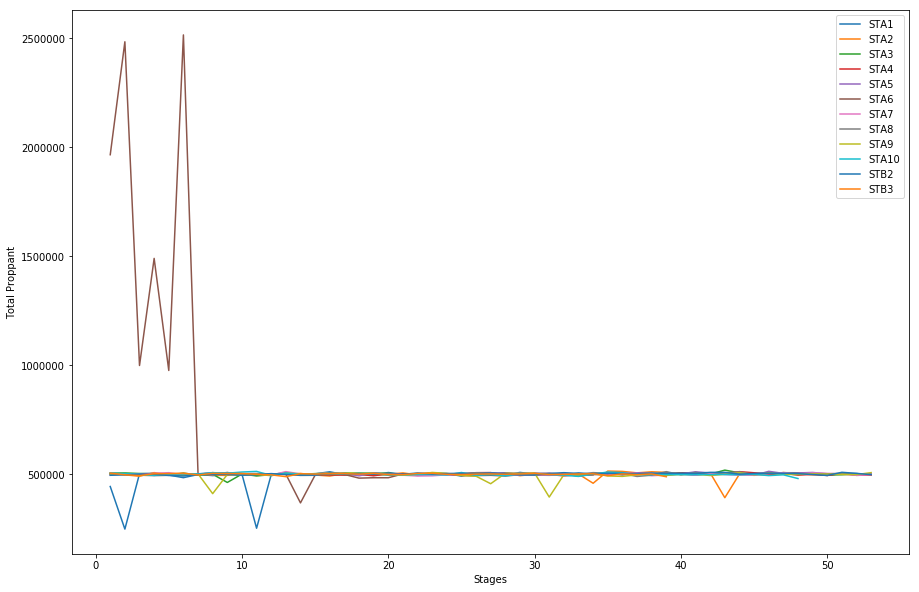

<Figure size 432x288 with 0 Axes>

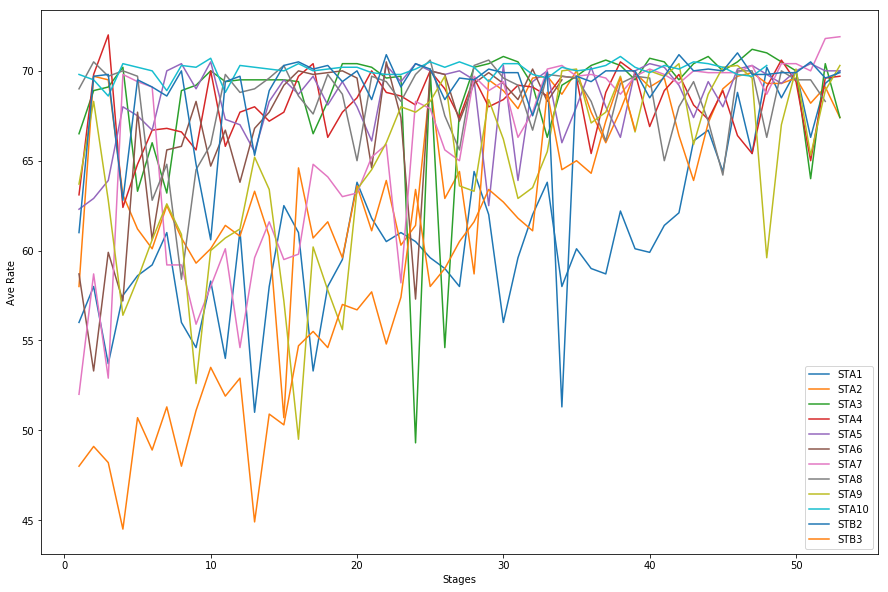

<Figure size 432x288 with 0 Axes>

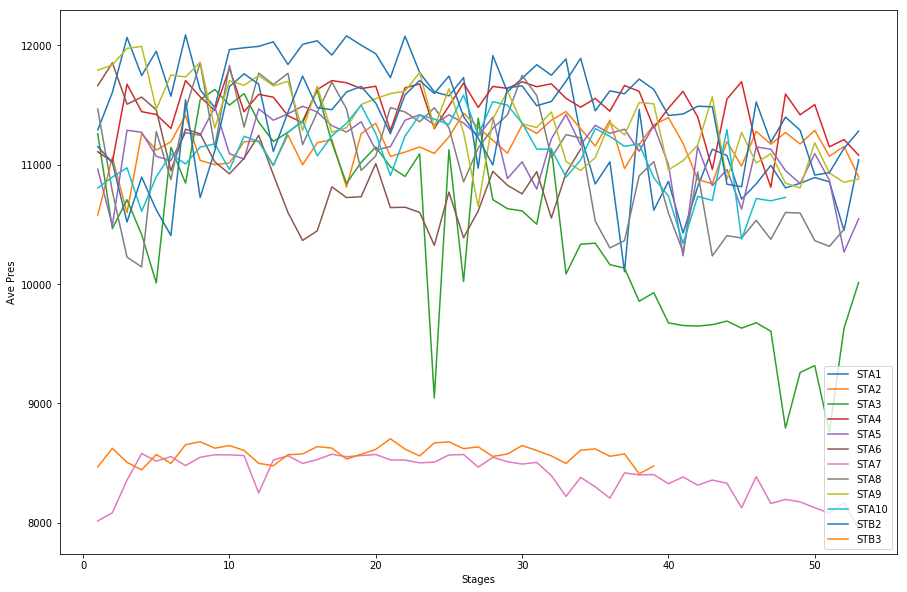

<Figure size 432x288 with 0 Axes>

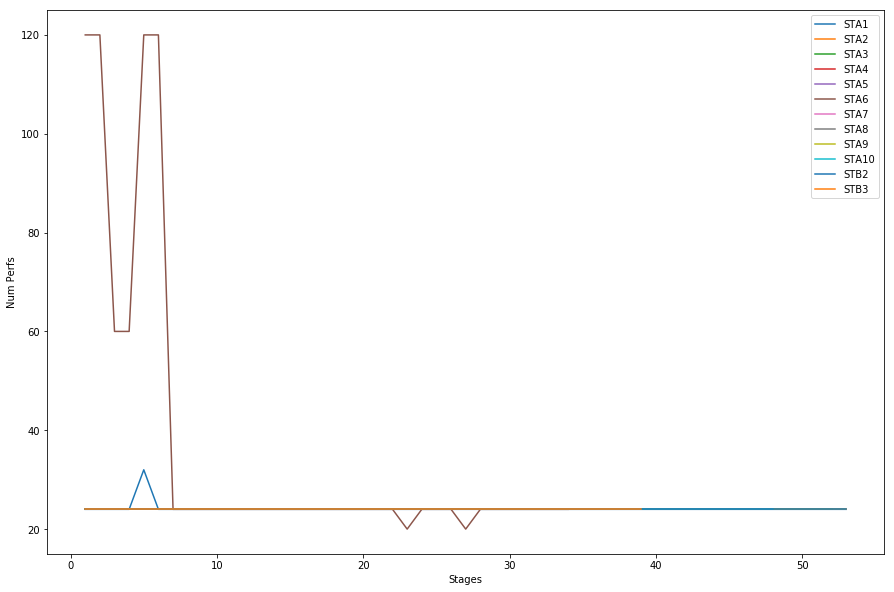

<Figure size 432x288 with 0 Axes>

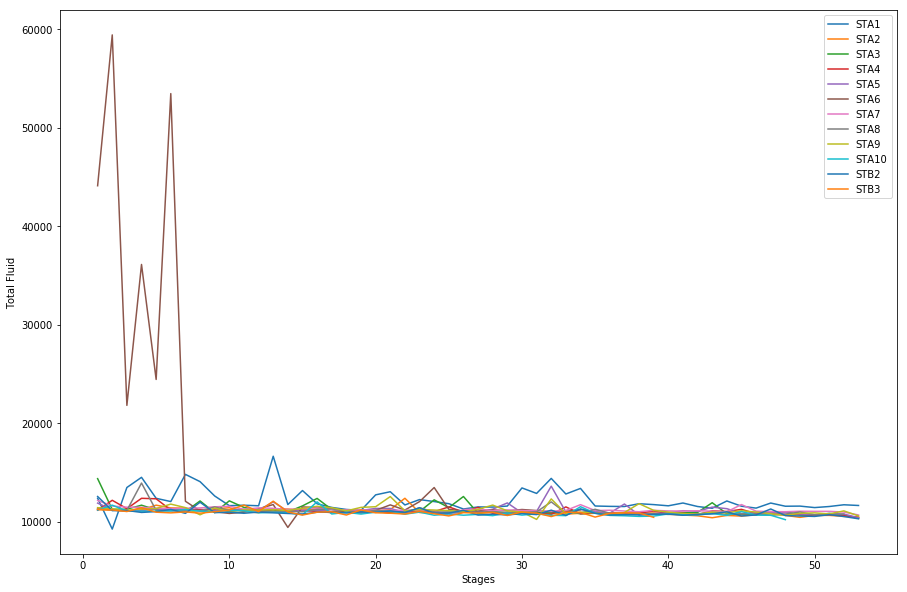

<Figure size 432x288 with 0 Axes>

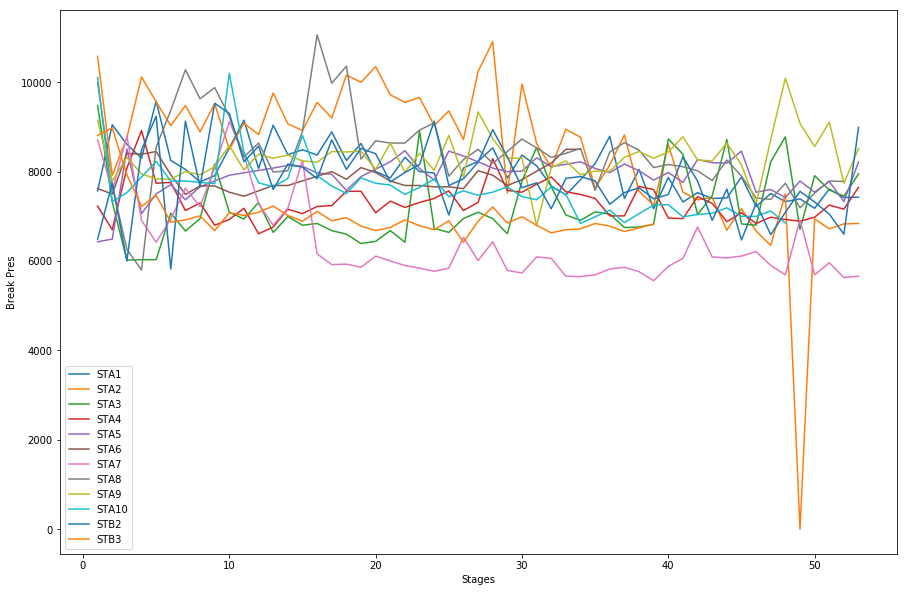

In [49]:
#Plot completion parameter for each well
for i in range(len(Comp_vars)):
    fig = plt.figure()
    plt.figure(figsize=(15,10))
    for well in dfs:
        #if well != 'STA6':
        ax = sns.lineplot(x = dfs[well]['Stages'], y = dfs[well][Comp_vars[i]], label = well)
        

In [43]:
T_vars = ['Ave Rate','Ave Pres']

for i in range(len(T_vars)):
    fig = plt.figure()
    for well in dfs:
        if well == 'STA6':
            ax = sns.lineplot(x = dfs[well]['Stages'], y = (dfs[well]['Ave Rate'],dfs[well]['Ave Pres']), label = well)
        

ValueError: array length 2 does not match index length 34

<Figure size 432x288 with 0 Axes>

In [ ]:
#ProdData_T

In [ ]:
#ProdData_T.reset_index()
#ProdData_T["Stage"]

ax = sns.lineplot(x="Stage", y="Average Rate, bpm", data=ProdData_T)

